In [ ]:
!unzip "/content/drive/MyDrive/food_classifier_data.zip"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from os import listdir
import skimage.exposure

In [4]:
train=pd.read_csv("/content/food_classifier_data/Training_set_food.csv")
test=pd.read_csv("/content/food_classifier_data/Testing_set_food.csv")
sub=pd.read_csv("/content/food_classifier_data/sample_submission.csv")

In [5]:
train.head()

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers


In [6]:
train["label"].value_counts()

Pizza         1800
burgers       1800
Softdrinks    1800
Name: label, dtype: int64

In [7]:
train.shape , test.shape

((5400, 2), (1800, 1))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


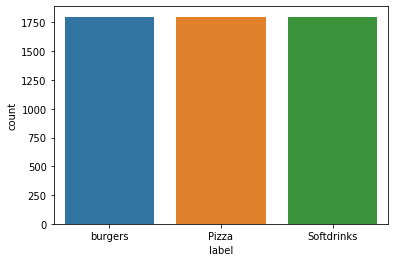

In [8]:
sns.countplot(train["label"],data=train)

In [9]:
lb=LabelEncoder()
train["food_no"]=lb.fit_transform(train["label"])

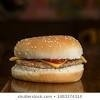

In [10]:
image=cv2.imread("food_classifier_data/train/Image_99.jpg")
image.shape
cv2_imshow(image)

In [11]:
image.shape

(100, 100, 3)

In [12]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [13]:
(X_train["label"].value_counts()/len(X_train))*100

Pizza         33.333333
burgers       33.333333
Softdrinks    33.333333
Name: label, dtype: float64

In [14]:
(X_valid["label"].value_counts()/len(X_valid))*100

burgers       33.333333
Softdrinks    33.333333
Pizza         33.333333
Name: label, dtype: float64

In [ ]:
# def preprocess(image):
#     kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
#     im = cv2.filter2D(image, -1, kernel)
#     out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
#     out1=(cv2.normalize(out2, (224,224),0, 255, cv2.NORM_MINMAX))
#     return im

In [15]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 )

In [16]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=X_train,
directory="/content/food_classifier_data/train",
x_col="filename",
y_col="label",
batch_size=16,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(299,299))

Found 4860 validated image filenames belonging to 3 classes.


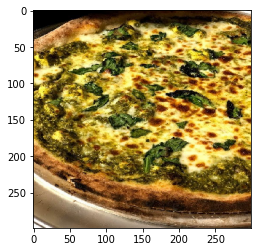

In [17]:

x,y = train_generator.next()
for i in range(8,9):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [18]:
valid_datagen=ImageDataGenerator(rescale=1./255.,)
valid_generator=valid_datagen.flow_from_dataframe( 
dataframe=X_valid,
directory="/content/food_classifier_data/train",
x_col="filename",
y_col="label",
batch_size=16,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(299,299))

Found 540 validated image filenames belonging to 3 classes.


In [1]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,ResNet152,EfficientNetB7, MobileNetV2,Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.CenterCrop(224,224),
    ]
)


In [24]:
inputs = keras.Input(shape=(299,299, 3))
tensor_x = data_augmentation(inputs)
resnet=InceptionResNetV2(weights="imagenet",input_tensor=tensor_x)

242900992/242900224 [==============================] - 3s 0us/step


In [25]:
x=resnet.layers[-2].output
fc1=Dense(3,kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005),activation='softmax')(x)
my_model=Model(inputs=resnet.input,outputs=fc1)

In [26]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________________________________________________________________________________

In [ ]:
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',verbose = 1,save_weights_only=True, save_best_only = True),
               EarlyStopping(monitor='val_accuracy', patience=3, verbose=0, mode='max'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [27]:
my_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.CategoricalCrossentropy())

In [28]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(my_model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

In [ ]:
my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

In [ ]:
my_model.load_weights(checkpoint_path)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = my_model.predict(valid_generator, STEP_SIZE_VALID)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = ['Burger', 'Pizza', 'Soft_Drink']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

In [ ]:
# extract = Model(my_model.inputs, my_model.layers[-2].output)
# features = extract.predict(valid_generator, STEP_SIZE_VALID)

In [ ]:
# from sklearn.model_selection import cross_val_score
# from lightgbm import LGBMClassifier
# lgb = LGBMClassifier()
# scores = cross_val_score(lgb, features,X_valid["food_no"], cv =5, scoring = "accuracy")
# scores.mean()

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.,)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/food_classifier_data/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(299,299))

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1800 validated image filenames.


In [ ]:
# fea = extract.predict(train_generator, STEP_SIZE_TRAIN)
# test_fea=extract.predict(test_generator,STEP_SIZE_TEST)

In [ ]:
# lgb.fit(fea,X_train["food_no"])
# test_predict=lgb.predict(test_fea)

In [ ]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

1800/1800 [==============================] - 40s 22ms/step


In [ ]:
prediction=lb.inverse_transform(pred1)
sub["prediction"]=prediction

In [ ]:
sub.prediction.value_counts()

Pizza         609
Softdrinks    607
burgers       584
Name: prediction, dtype: int64

In [ ]:
sub.to_csv("pred-inc1.csv",index=False)